In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(df_train.info())
print("--------------")
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    i

In [5]:
df_train=df_train.drop(['Name','Ticket','Cabin'],axis=1)
df_test=df_test.drop(['Name','Ticket','Cabin'],axis=1)

### [탐색적 데이터 분석]

0    549
1    342
Name: Survived, dtype: int64


<AxesSubplot:>

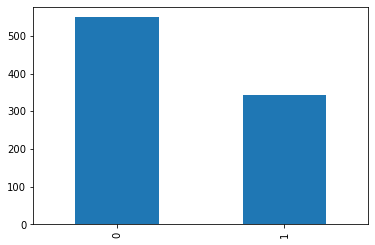

In [6]:
print(df_train['Survived'].value_counts())
df_train['Survived'].value_counts().plot.bar()

3    491
1    216
2    184
Name: Pclass, dtype: int64


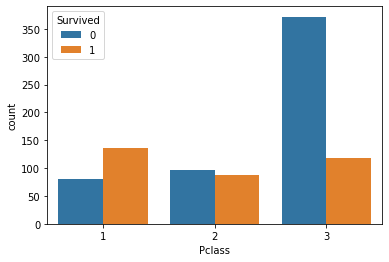

In [8]:
# Pclass에 따른 분포를 살펴본다
print(df_train['Pclass'].value_counts())
ax=sns.countplot(x='Pclass',hue='Survived',data=df_train)

In [9]:
from scipy import stats

# 두 집단의 피처를 비교하면서 탐색작업을 자동화하는 함수 정의
def valid_features(df,col_name,distribution_check=True):
    
    # Survived의 분포 그래프 출력
    g=sns.FacetGrid(df,col='Survived')
    g.map(plt.hist,col_name,bins=30)
    
    # Survived의 표준편차 각각 출력
    titanic_survived=df[df['Survived']==1]
    titanic_survived_static=np.array(titanic_survived[col_name])
    print("data std is","%.2f"%np.std(titanic_survived_static))
    titanic_n_survived=df[df['Survived']==0]
    titanic_n_survived_static=np.array(titanic_n_survived[col_name])
    print("data std is","%.2f"%np.std(titanic_n_survived_static))
    
    # T-test로 두 집단의 평균 차이 결정
    tTestResult=stats.ttest_ind(titanic_survived[col_name],titanic_n_survived[col_name])
    tTestResultDiffVar=stats.ttest_ind(titanic_survived[col_name],titanic_n_survived[col_name],equal_var=False)
    print("The t-statistic and p-value assuming equal variances is %.3f and %.3f"%tTestResult)
    print("The t-statistic and p-value not assuming equal variances is %.3f and %.3f"%tTestResultDiffVar)
    
    if distribution_check:
        print("The w-statistic and p-value in Survived %.3f and %.3f"%stats.shapiro(titanic_survived[col_name]))
        print("The w-statistic and p-value in Non-Survived %.3f and %.3f"%stats.shapiro(titanic_n_survived[col_name]))

data std is 14.93
data std is 14.16
The t-statistic and p-value assuming equal variances is -2.067 and 0.039
The t-statistic and p-value not assuming equal variances is -2.046 and 0.041
The w-statistic and p-value in Survived 0.983 and 0.001
The w-statistic and p-value in Non-Survived 0.969 and 0.000


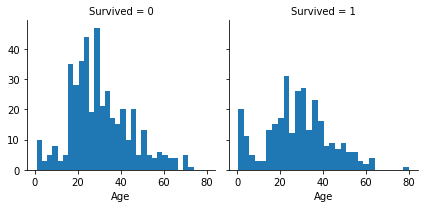

In [11]:
valid_features(df_train[df_train['Age']>0],'Age',distribution_check=True)

data std is 0.61
data std is 1.76
The t-statistic and p-value assuming equal variances is -4.872 and 0.000
The t-statistic and p-value not assuming equal variances is -5.136 and 0.000
The w-statistic and p-value in Survived 0.423 and 0.000
The w-statistic and p-value in Non-Survived 0.633 and 0.000


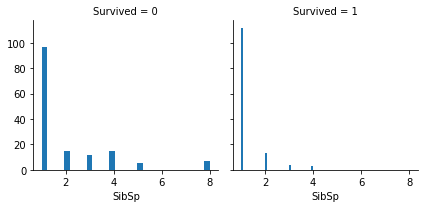

In [13]:
valid_features(df_train[df_train['SibSp']>0],'SibSp',distribution_check=True)

## 생존자 분류 모델 만들기

In [14]:
replace_mean=df_train[df_train['Age']>0]['Age'].mean()
df_train['Age']=df_train['Age'].fillna(replace_mean)
df_test['Age']=df_test['Age'].fillna(replace_mean)

embarked_mode=df_train['Embarked'].value_counts().index[0]
df_train['Embarked']=df_train['Embarked'].fillna(embarked_mode)
df_test['Embarked']=df_test['Embarked'].fillna(embarked_mode)

# one-hot encoding을 위한 통합 데이터 프레임 생성
whole_df=df_train.append(df_test)
train_idx_num=len(df_train)

# one-hot encoding 수행
whole_df_encoded=pd.get_dummies(whole_df)
df_train=whole_df_encoded[:train_idx_num]
df_test=whole_df_encoded[train_idx_num:]

df_train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,22.0,1,0,7.2500,0,1,0,0,1
1,2,1.0,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,1.0,3,26.0,0,0,7.9250,1,0,0,0,1
3,4,1.0,1,35.0,1,0,53.1000,1,0,0,0,1
4,5,0.0,3,35.0,0,0,8.0500,0,1,0,0,1


In [15]:
x_train,y_train=df_train.loc[:,df_train.columns!='Survived'].values,df_train['Survived'].values
x_test,y_test=df_test.loc[:,df_test.columns!='Survived'].values,df_test['Survived'].values

### Logistic Regression